In [1]:
import gym, tiles3

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class StateSpaceTiler:
    def __init__(self, size, tilings, num_tiles, x_min, x_max, y_min, y_max):
        self.iht = tiles3.IHT(size)
        self.tilings = tilings
        self.num_tiles = num_tiles
        self.x_transform = lambda x: ((x - x_min)*self.num_tiles)/(x_max - x_min)
        self.y_transform = lambda y: ((y - y_min)*self.num_tiles)/(y_max - y_min)
    
    def get_encoding(self, x, y):
        return np.array(tiles3.tiles(self.iht, self.tilings, [self.x_transform(x), self.y_transform(y)]))

In [4]:
class Agent:
    def __init__(self, params, train=False):
        self.alpha_r = params.get("alpha_r")
        self.tilings = params.get("tilings")
        self.num_tiles = params.get("num_tiles")
        self.action_values = params.get("actions")
        self.iht_size = params.get("iht_size")
        self.alpha_w = params.get("alpha_w")/self.tilings
        self.alpha_theta =  params.get("alpha_t")/self.tilings
        self.tiler = StateSpaceTiler(self.iht_size,self.tilings, self.num_tiles, -np.pi, np.pi, -2*np.pi, 2*np.pi)
        self.weights = np.zeros((self.iht_size, ))
        self.policy = np.zeros((len(self.action_values), self.iht_size))
        self.reward_mean = 0
        if not train:
            self.load()
    
    def get_reward(self):
        return self.reward_mean
    def save(self):
        np.save('policy.npy', self.policy)
        np.save('weights.npy', self.weights)
        
    def load(self):
        self.weights = np.load('weights.npy')
        self.policy  = np.load('policy.npy')
    
    def softmax_dist(self, state):
        return np.sum(self.policy[:, state], axis=-1)
    
    def process(self, position):
        sign = position/abs(position)
        position = abs(position) % (2*np.pi)
        if position > np.pi:
            position -= 2*np.pi
        return position*sign
    
    def softmax_prob(self, state):
        dist = self.softmax_dist(state)
        max_val = np.max(dist)
        dist -= max_val
        p = np.exp(dist)
        return p/(np.sum(p))
    def softmax_action(self, state):
        return np.random.choice(len(self.action_values), p = self.softmax_prob(state))
        
    def agent_init(self, env_state):
        position, self.velocity = env_state
        self.position = self.process(position)
        self.previous_state = self.tiler.get_encoding(self.position, self.velocity)
        self.previous_action = self.softmax_action(self.previous_state)
        
        return self.action_values[self.previous_action] 

    def get_value(self, state):
        return (np.sum(self.weights[state]))
    
    def agent_step(self, env_state, reward):
        position, self.velocity = env_state
        self.position = self.process(position)
        current_state = self.tiler.get_encoding(self.position, self.velocity)
        td_error = reward - self.reward_mean + self.get_value(current_state) - self.get_value(self.previous_state)
        self.reward_mean = (self.reward_mean + self.alpha_r*td_error)/(1+self.alpha_r)
        
        self.weights[self.previous_state] += self.alpha_w*td_error
        prob_dist = self.softmax_prob(self.previous_state)
        for action in range(len(self.action_values)):
            prob_scale = -prob_dist[action]
            if action == self.previous_action:
                prob_scale = 1  - prob_dist[action]
            self.policy[action][self.previous_state] += self.alpha_theta*td_error*prob_scale
        
        self.previous_state = current_state
        self.previous_action = self.softmax_action(self.previous_state)
        
        return self.action_values[self.previous_action]
    
    def play(self, env_state):
        position, velocity = env_state
        position = self.process(position)
        current_state = self.tiler.get_encoding(position, velocity)
        dist = self.softmax_prob(current_state)
        
        return self.action_values[np.argmax(dist)]
    
        
        

In [5]:
env = gym.make('Pendulum-v0')

In [6]:
agent_params = {
    "alpha_r": 2**-6,
    "tilings": 32,
    "num_tiles": 8,
    "actions": [-1, 0, 1],
    "iht_size": 4096, 
    "alpha_w": 0.001,
    "alpha_t": 2**(-5),
}

In [7]:
agent = Agent(agent_params)

In [8]:
def train(agent, agent_params, env):
    num_steps = 1200000
    env.reset()
    action = agent.agent_init(env.state)

    x_points = []
    y_points = []
    for _ in range(num_steps):
        observation, reward, done, info = env.step([action])
        env.render()
        action = agent.agent_step(env.state, reward)
        if _ % 10000 == 0:
            print ("Cycle {0} Value is {1}".format(_//10000, agent.get_reward()))
            print ("State is Position: {0}, Velocity {1}".format(agent.position, agent.velocity))
            x_points.append(_/1000)
            y_points.append(agent.get_reward())
    plt.plot(x_points, y_points)
    plt.show()
    agent.save()

In [13]:
def test(agent, env):
    env.reset()
    print ("Starting state is ")
    print (env.state)
    play_steps = 10000
    for _ in range(play_steps):
        action = agent.play(env.state)
        env.step([action])
        env.render()

Cycle 0 Value is -3.380835837041512
State is Position: -0.4521941004401716, Velocity -0.3609249285424341
Cycle 1 Value is -3.5778929833694084
State is Position: 0.6175214857356082, Velocity 5.357150914077415
Cycle 2 Value is -3.543689239778388
State is Position: -2.5915881133952965, Velocity 8.0
Cycle 3 Value is -3.383166357550224
State is Position: 0.7969527693340481, Velocity 5.674367194760356
Cycle 4 Value is -3.615711385203147
State is Position: -0.34739942042591565, Velocity 4.756310752088834
Cycle 5 Value is -3.6273656908552354
State is Position: -1.4333902852039913, Velocity 6.60605303870191
Cycle 6 Value is -3.560290458956503
State is Position: -2.9972285745524943, Velocity 8.0
Cycle 7 Value is -3.3793444005616746
State is Position: 0.5189950177230571, Velocity 5.16730234794341
Cycle 8 Value is -3.5481858759643607
State is Position: -2.1090845966461487, Velocity 7.659873069963478
Cycle 9 Value is -3.54091383500746
State is Position: 1.8207336918163222, Velocity 7.95197010086685

Cycle 79 Value is -2.384138273940686
State is Position: 0.8553059129712111, Velocity 3.3253573237289737
Cycle 80 Value is -2.4401408655271197
State is Position: 0.7406854428451908, Velocity 0.7176058336416439
Cycle 81 Value is -1.8850875778657943
State is Position: 1.7839768716211495, Velocity -5.0652193052862815
Cycle 82 Value is -1.6116597735529885
State is Position: 0.979818120361351, Velocity -3.232465966421983
Cycle 83 Value is -2.022538457895384
State is Position: -0.8273448407426542, Velocity 1.9697861102637757
Cycle 84 Value is -1.2631567247496507
State is Position: 0.2178546094094358, Velocity 1.4927269970873769
Cycle 85 Value is -2.136786752797141
State is Position: -3.0748669086720355, Velocity -7.855827051372712
Cycle 86 Value is -1.9721420587094038
State is Position: -0.22639287169470634, Velocity -1.495014536778281
Cycle 87 Value is -1.84702270542102
State is Position: 0.9954721848039938, Velocity -3.6266587440057467
Cycle 88 Value is -1.9797829963774802
State is Position

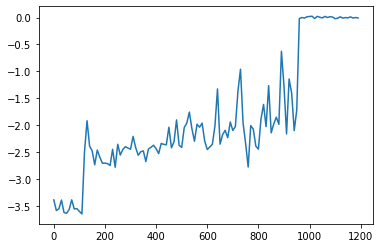

In [15]:
train(agent, agent_params, env)

In [16]:
test(agent, env)

Starting state is 
[-0.53304822 -0.70810077]


In [17]:
agent.policy = np.loadtxt('policy.csv', delimiter=',')
agent.weights = np.loadtxt('weights.csv', delimiter=',')
env.close()